<a href="https://colab.research.google.com/github/harshbelani/M.Tech-DS/blob/master/Deep_Learning/DL_Assignment_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import os
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip -P data

--2020-11-03 22:12:11--  https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1543989 (1.5M) [application/x-httpd-php]
Saving to: ‘data/AirQualityUCI.zip’

AirQualityUCI.zip   100%[===================>]   1.47M  3.78MB/s    in 0.4s    

2020-11-03 22:12:12 (3.78 MB/s) - ‘data/AirQualityUCI.zip’ saved [1543989/1543989]



In [3]:
import zipfile
with zipfile.ZipFile('/content/data/AirQualityUCI.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

In [4]:
data = pd.read_excel("/content/data/AirQualityUCI.xlsx")

In [5]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [6]:
data["Date Time"] = data["Date"].astype(str) + ' ' + data["Time"].astype(str)

In [7]:
data = data[5::6]

date_time = pd.to_datetime(data.pop('Date Time'), format='%Y-%m-%d %H:%M:%S')
data.pop("Date")
data.pop("Time")

5       23:00:00
11      05:00:00
17      11:00:00
23      17:00:00
29      23:00:00
          ...   
9329    11:00:00
9335    17:00:00
9341    23:00:00
9347    05:00:00
9353    11:00:00
Name: Time, Length: 1559, dtype: object

In [8]:
data.replace(-200, 0, inplace=True)
data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000
mean,1.610455,1033.786348,17.128929,8.724172,866.826866,193.464464,829.406243,93.243169,1362.306446,945.972685,17.874123,46.558130,0.982354
std,1.394299,292.392779,73.209448,6.852530,304.559125,208.184137,307.494054,58.960947,423.831466,419.244324,9.570988,19.837927,0.442972
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.275000,0.000000,0.000000
25%,0.550000,906.000000,0.000000,3.544659,684.875000,55.000000,666.000000,53.000000,1157.250000,677.625000,11.050000,32.125000,0.689122
50%,1.400000,1033.000000,0.000000,7.252462,867.750000,133.100000,818.250000,95.000000,1420.000000,907.750000,17.450000,47.750000,0.973757
75%,2.400000,1191.375000,0.000000,12.338012,1061.250000,251.400000,991.250000,130.000000,1631.250000,1201.500000,24.562500,61.875000,1.296532
max,8.400000,1914.500000,832.000000,46.277657,1897.000000,1290.000000,2559.250000,332.600000,2640.750000,2493.500000,43.424999,87.174999,2.119450


In [9]:
data["T"] = data["T"].apply(lambda x : x if x>=0 else 0)
data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000
mean,1.610455,1033.786348,17.128929,8.724172,866.826866,193.464464,829.406243,93.243169,1362.306446,945.972685,17.875102,46.558130,0.982354
std,1.394299,292.392779,73.209448,6.852530,304.559125,208.184137,307.494054,58.960947,423.831466,419.244324,9.569103,19.837927,0.442972
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.550000,906.000000,0.000000,3.544659,684.875000,55.000000,666.000000,53.000000,1157.250000,677.625000,11.050000,32.125000,0.689122
50%,1.400000,1033.000000,0.000000,7.252462,867.750000,133.100000,818.250000,95.000000,1420.000000,907.750000,17.450000,47.750000,0.973757
75%,2.400000,1191.375000,0.000000,12.338012,1061.250000,251.400000,991.250000,130.000000,1631.250000,1201.500000,24.562500,61.875000,1.296532
max,8.400000,1914.500000,832.000000,46.277657,1897.000000,1290.000000,2559.250000,332.600000,2640.750000,2493.500000,43.424999,87.174999,2.119450


In [10]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [11]:
day = 24*60*60
year = (365.2425)*day

data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

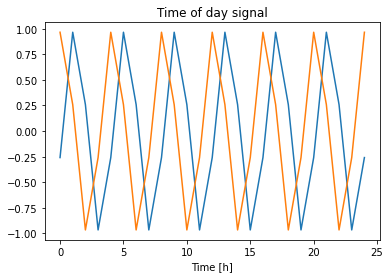

In [12]:
plt.plot(np.array(data['Day sin'])[:25])
plt.plot(np.array(data['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [14]:
column_indices = {name: i for i, name in enumerate(data.columns)}

n = len(data)
train_df = data[0:int(n*0.7)]
val_df = data[int(n*0.7):int(n*0.9)]
test_df = data[int(n*0.9):]

num_features = data.shape[1]

In [15]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

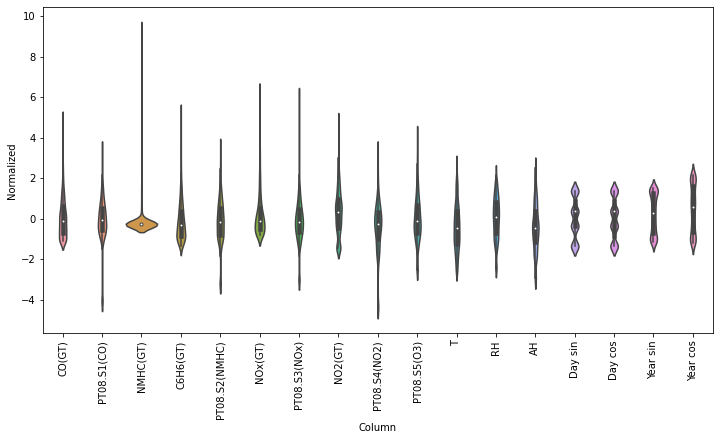

In [16]:
df_std = (data - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(data.keys(), rotation=90)

In [17]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [18]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['AH'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['AH']

In [19]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['AH'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['AH']

In [20]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [21]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 17)
Inputs shape: (3, 6, 17)
labels shape: (3, 1, 1)


In [22]:
w2.example = example_inputs, example_labels

In [24]:
def plot(self, model=None, plot_col='AH', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

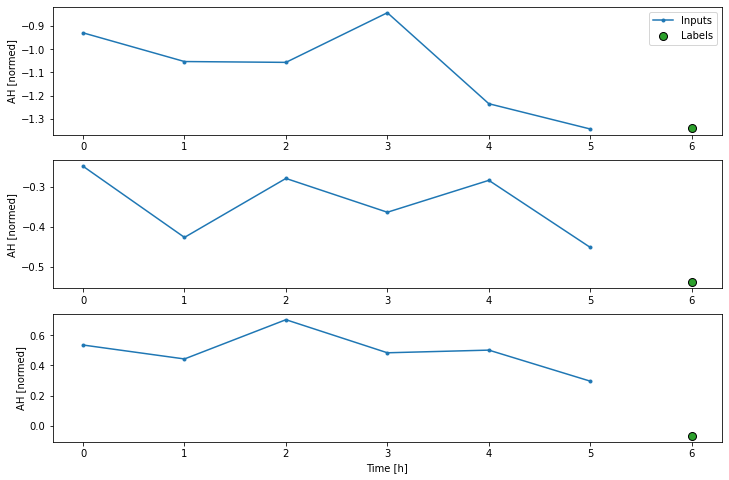

In [25]:
w2.plot()

In [26]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [28]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [29]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 17), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [30]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 17)
Labels shape (batch, time, features): (32, 1, 1)


In [31]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['AH'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['AH']

In [32]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 17)
Labels shape (batch, time, features): (32, 1, 1)


In [33]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [34]:
baseline = Baseline(label_index=column_indices['AH'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

10/10 [==============================] - 0s 2ms/step - loss: 0.1522 - mean_absolute_error: 0.1946


In [35]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['AH'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['AH']

In [36]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 17)
Output shape: (32, 1, 1)


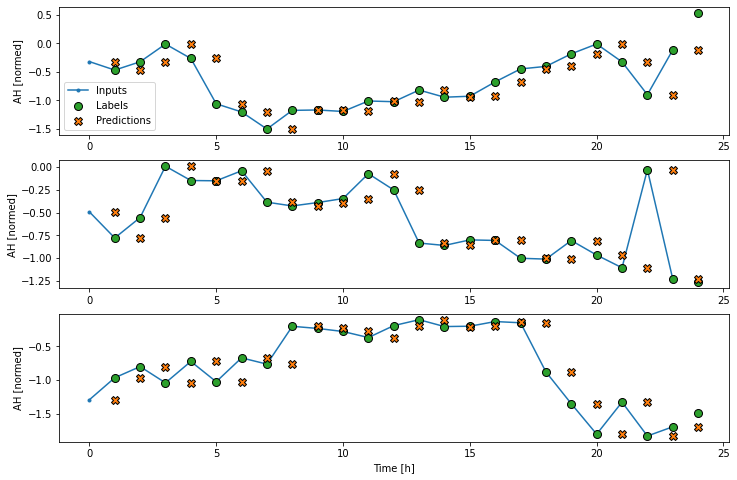

In [37]:
wide_window.plot(baseline)

In [38]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)])

In [39]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 17)
Output shape: (32, 1, 1)


In [40]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [41]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/100
35/35 [==============================] - 0s 7ms/step - loss: 2.6880 - mean_absolute_error: 1.2996 - val_loss: 2.5133 - val_mean_absolute_error: 1.3360
Epoch 2/100
35/35 [==============================] - 0s 4ms/step - loss: 2.0426 - mean_absolute_error: 1.1372 - val_loss: 1.8712 - val_mean_absolute_error: 1.1503
Epoch 3/100
35/35 [==============================] - 0s 4ms/step - loss: 1.5780 - mean_absolute_error: 1.0017 - val_loss: 1.4574 - val_mean_absolute_error: 1.0116
Epoch 4/100
35/35 [==============================] - 0s 4ms/step - loss: 1.2661 - mean_absolute_error: 0.8965 - val_loss: 1.1783 - val_mean_absolute_error: 0.9037
Epoch 5/100
35/35 [==============================] - 0s 4ms/step - loss: 1.0580 - mean_absolute_error: 0.8179 - val_loss: 1.0332 - val_mean_absolute_error: 0.8366
Epoch 6/100
35/35 [==============================] - 0s 4ms/step - loss: 0.9304 - mean_absolute_error: 0.7624 - val_loss: 0.9417 - val_mean_absolute_error: 0.7820
Epoch 7/100
35/35 [===

In [42]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 17)
Output shape: (32, 24, 1)


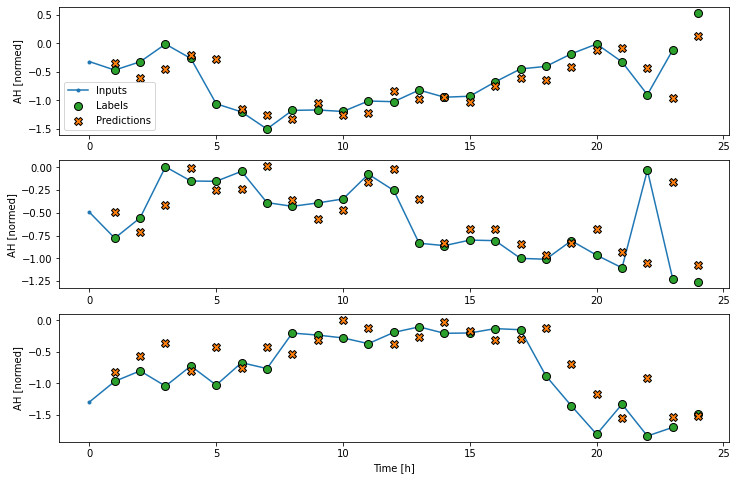

In [43]:
wide_window.plot(linear)

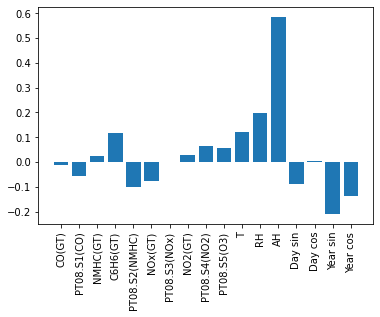

In [44]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [45]:
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['AH']

In [46]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/100
35/35 [==============================] - 0s 9ms/step - loss: 0.5278 - mean_absolute_error: 0.5268 - val_loss: 0.2705 - val_mean_absolute_error: 0.3805
Epoch 2/100
35/35 [==============================] - 0s 6ms/step - loss: 0.2613 - mean_absolute_error: 0.3497 - val_loss: 0.2271 - val_mean_absolute_error: 0.3525
Epoch 3/100
35/35 [==============================] - 0s 5ms/step - loss: 0.2239 - mean_absolute_error: 0.3106 - val_loss: 0.1808 - val_mean_absolute_error: 0.2931
Epoch 4/100
35/35 [==============================] - 0s 5ms/step - loss: 0.2063 - mean_absolute_error: 0.2881 - val_loss: 0.2101 - val_mean_absolute_error: 0.3133
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 0.1920 - mean_absolute_error: 0.3056


In [47]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 17)
Output shape: (32, 24, 1)


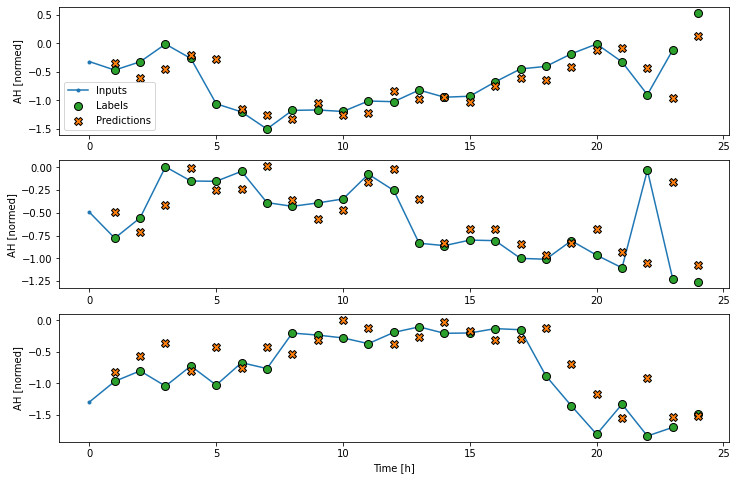

In [48]:
wide_window.plot(linear)

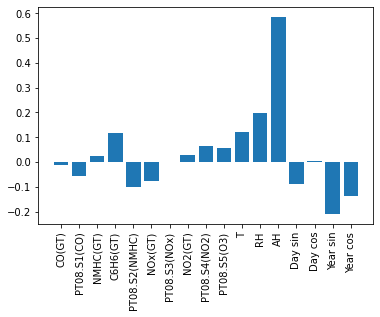

In [49]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [50]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/100
35/35 [==============================] - 0s 9ms/step - loss: 0.5115 - mean_absolute_error: 0.5140 - val_loss: 0.3149 - val_mean_absolute_error: 0.4111
Epoch 2/100
35/35 [==============================] - 0s 6ms/step - loss: 0.2569 - mean_absolute_error: 0.3343 - val_loss: 0.2245 - val_mean_absolute_error: 0.3461
Epoch 3/100
35/35 [==============================] - 0s 5ms/step - loss: 0.2236 - mean_absolute_error: 0.3021 - val_loss: 0.2363 - val_mean_absolute_error: 0.3777
Epoch 4/100
35/35 [==============================] - 0s 5ms/step - loss: 0.2136 - mean_absolute_error: 0.2942 - val_loss: 0.1739 - val_mean_absolute_error: 0.2743
Epoch 5/100
35/35 [==============================] - 0s 5ms/step - loss: 0.2077 - mean_absolute_error: 0.2909 - val_loss: 0.1571 - val_mean_absolute_error: 0.2424
Epoch 6/100
35/35 [==============================] - 0s 5ms/step - loss: 0.1967 - mean_absolute_error: 0.2783 - val_loss: 0.1631 - val_mean_absolute_error: 0.2537
Epoch 7/100
10/10 [===

In [51]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['AH'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['AH']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

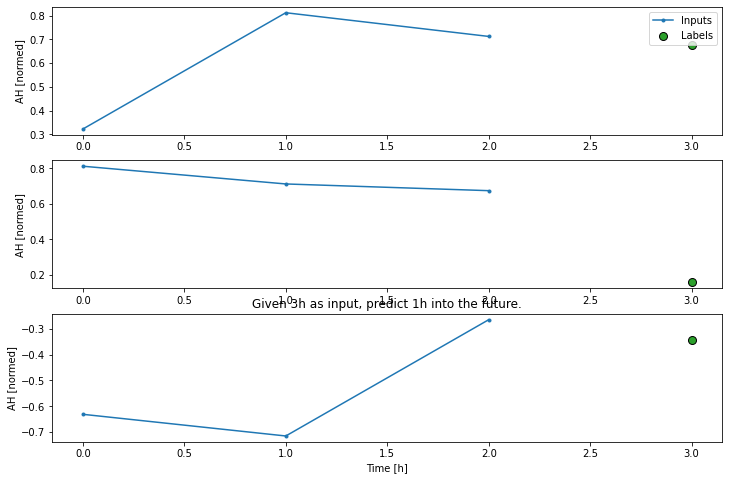

In [52]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

In [54]:
multi_step_dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1]),
])

In [55]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 17)
Output shape: (32, 1, 1)


In [56]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

10/10 [==============================] - 0s 2ms/step - loss: 0.2516 - mean_absolute_error: 0.3620


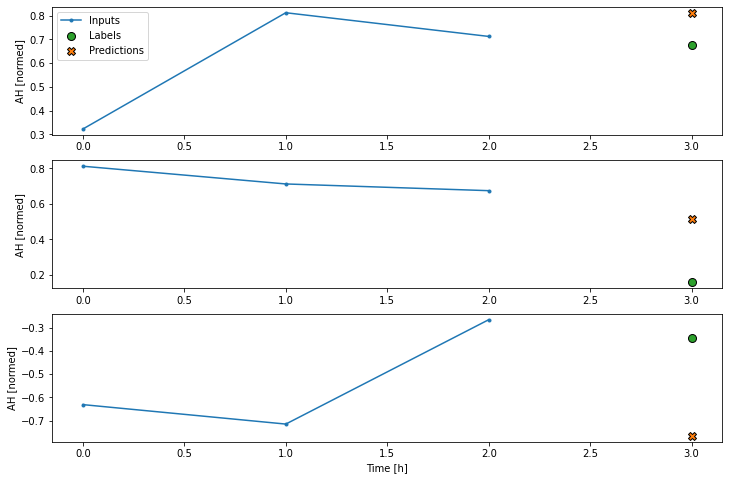

In [57]:
conv_window.plot(multi_step_dense)

In [58]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 17)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,408], In[1]: [51,32] [Op:MatMul]


In [59]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [60]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 17)
Output shape: (32, 1, 1)


In [61]:

history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

10/10 [==============================] - 0s 2ms/step - loss: 0.2806 - mean_absolute_error: 0.3941


In [62]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 17)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [63]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['AH'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['AH']

In [64]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 17)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


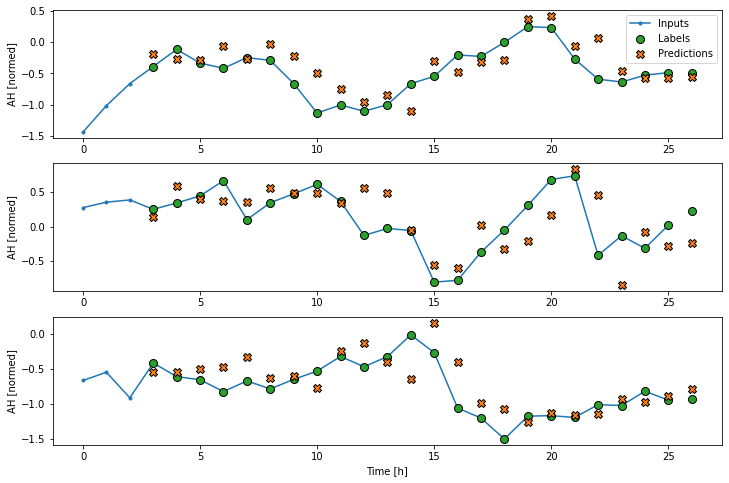

In [65]:

wide_conv_window.plot(conv_model)

In [66]:

single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 17)
Labels shape (batch, time, features): (32, 24, 17)
